In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy.stats import entropy

# Dark Theme
plt.style.use('dark_background')
plt.rcParams['figure.facecolor'] = '#121212'
plt.rcParams['axes.facecolor'] = '#121212'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.2
plt.rcParams['grid.color'] = '#ffffff'

def calculate_kinematics(price_array, window=21, poly=2):
    """Extracts smoothed price, velocity, and acceleration."""
    # Smoothed Position (Zero-Lag Price)
    pos = savgol_filter(price_array, window_length=window, polyorder=poly)
    # 1st Derivative (Velocity)
    vel = savgol_filter(price_array, window_length=window, polyorder=poly, deriv=1)
    # 2nd Derivative (Acceleration)
    acc = savgol_filter(price_array, window_length=window, polyorder=poly, deriv=2)
    
    return pos, vel, acc

def calculate_entropy(vel_array, lookback=30):
    """Calculates rolling Shannon Entropy of the velocity vector."""
    ent = np.full(len(vel_array), np.nan)
    for i in range(lookback, len(vel_array)):
        window = vel_array[i-lookback : i+1]
        counts, _ = np.histogram(window, bins='doane', density=True)
        probs = counts / np.sum(counts)
        ent[i] = entropy(probs, base=2)
    return ent

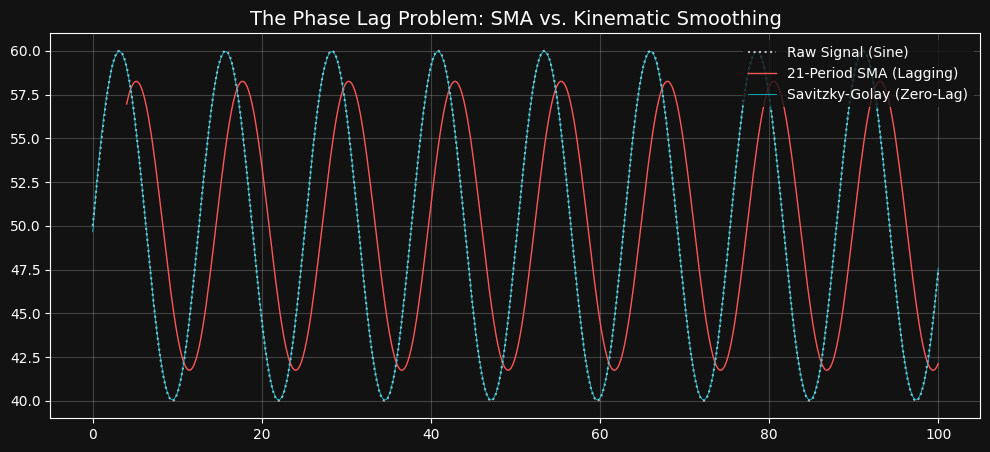

In [22]:
# 1. Generate Synthetic Pure Sine Wave
t = np.linspace(0, 100, 500)
pure_sine = np.sin(t * 0.5) * 10 + 50

# 2. Calculate Indicators
sma_21 = pd.Series(pure_sine).rolling(window=21).mean().values
sg_pos, sg_vel, sg_acc = calculate_kinematics(pure_sine, window=21)

# 3. Plotting the Lag Proof
fig, ax1 = plt.subplots(figsize=(12, 5))

ax1.plot(t, pure_sine, color='#ffffff', label='Raw Signal (Sine)', linestyle=':', alpha=0.7)
ax1.plot(t, sma_21, color='#ff5555', label='21-Period SMA (Lagging)', linewidth=1.0)
ax1.plot(t, sg_pos, color='#00e5ff', label='Savitzky-Golay (Zero-Lag)', linewidth=0.5)

ax1.set_title("The Phase Lag Problem: SMA vs. Kinematic Smoothing", fontsize=14, color='white')
ax1.legend(loc='upper right', facecolor='#121212', edgecolor='none')
plt.show()

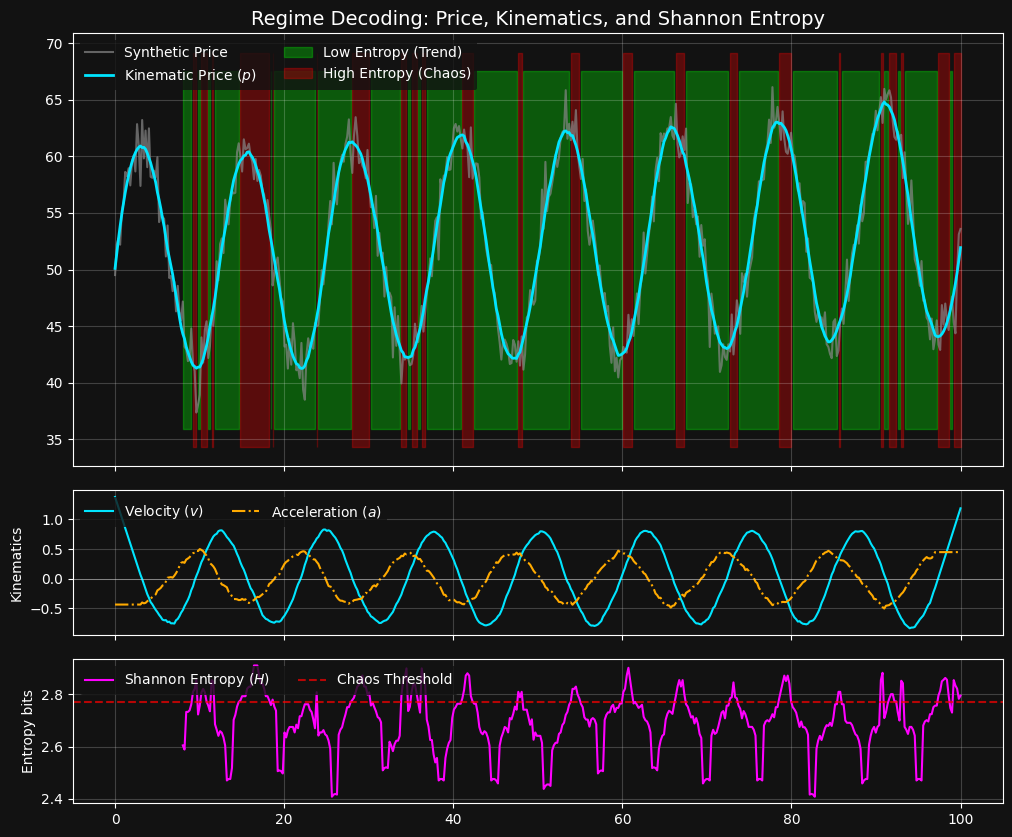

In [27]:
# 1. Generate Synthetic Price (Sine + Exponential Trend + Noise)
trend = np.exp(t * 0.015)
noise = np.random.normal(0, 1.5, size=len(t))
synthetic_price = pure_sine + trend + noise

# 2. Calculate Kinematics & Entropy
sg_pos, sg_vel, sg_acc = calculate_kinematics(synthetic_price, window=31, poly=2)
ent_signal = calculate_entropy(sg_vel, lookback=40)

# 3. Define the "Chaos" Threshold (Top 25% of entropy readings = Red)
chaos_threshold = np.nanpercentile(ent_signal, 75)

# 4. Multi-Panel Plot Setup
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1, 1]})
plt.subplots_adjust(hspace=0.1)

# --- PANEL 1: PRICE & REGIME BACKGROUND ---
ax1.plot(t, synthetic_price, color='#888888', label='Synthetic Price', alpha=0.7)
ax1.plot(t, sg_pos, color='#00e5ff', label='Kinematic Price ($p$)', linewidth=2)

# Shade Background based on Entropy
ax1.fill_between(t, ax1.get_ylim()[0], ax1.get_ylim()[1], where=(ent_signal <= chaos_threshold), color='#00ff00', alpha=0.3, label='Low Entropy (Trend)')
ax1.fill_between(t, ax1.get_ylim()[0], ax1.get_ylim()[1], where=(ent_signal > chaos_threshold), color='#ff0000', alpha=0.3, label='High Entropy (Chaos)')

ax1.set_title("Regime Decoding: Price, Kinematics, and Shannon Entropy", fontsize=14)
ax1.legend(loc='upper left', facecolor='#121212', edgecolor='none', ncol=2)

# --- PANEL 2: VELOCITY & ACCELERATION ---
ax2.plot(t, sg_vel, color='#00e5ff', label='Velocity ($v$)')
ax2.plot(t, sg_acc * 5, color='#ffaa00', label='Acceleration ($a$)', linestyle='-.') # Scaled for visibility
ax2.axhline(0, color='white', linewidth=0.5, alpha=0.5)
ax2.legend(loc='upper left', facecolor='#121212', edgecolor='none', ncol=2)
ax2.set_ylabel("Kinematics")

# --- PANEL 3: SHANNON ENTROPY ---
ax3.plot(t, ent_signal, color='#ff00ff', label='Shannon Entropy ($H$)')
ax3.axhline(chaos_threshold, color='#ff0000', linestyle='--', label='Chaos Threshold', alpha=0.7)
ax3.legend(loc='upper left', facecolor='#121212', edgecolor='none', ncol=2)
ax3.set_ylabel("Entropy bits")

plt.show()

### ⚠️ Beyond Static Thresholds

This notebook demonstrates a simplified, static-threshold approach to Entropy. 

In live markets, thresholds are dynamic. The **Impulse-X Terminal** utilizes a synchronized **Hidden Markov Model (HMM)** to mathematically synthesize Velocity, Acceleration, and Entropy into a real-time probabilistic regime state without relying on arbitrary cutoffs.

**[Read the Full Mathematical Derivation & HMM Specs](https://konvsys.github.io/impulse-docs)**